In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas()

In [3]:
df = data.data

In [4]:
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df = df['co2'].resample('MS').mean()

In [6]:
df.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [7]:
df.isnull().sum()

5

In [8]:
df = df.fillna(df.bfill())

In [9]:
df.isnull().sum()

0

In [10]:
train = df[:'1997-12-01']
test = df['1998-01-01':]

In [11]:
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [12]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

In [13]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Fri, 21 Jul 2023   AIC                           1157.537
Time:                        00:10:19   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721012
1998-04-01    366.959404
1998-05-01    367.094543
Freq: MS, Name: predicted_mean, dtype: float64

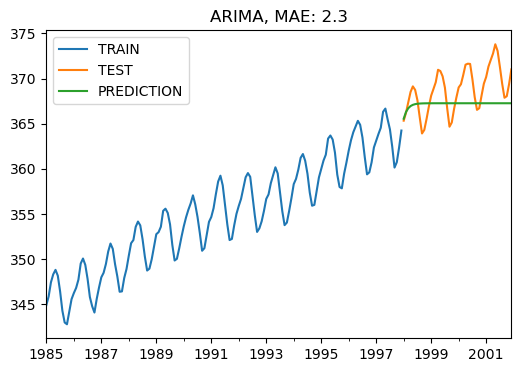

In [15]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show(block=True)
    
plot_co2(train, test, y_pred, "ARIMA")

In [16]:
# Hyperparameter Optimization

In [17]:
# AIC & BIC

In [18]:
p = d = q = range(1, 4)
pdq = list(itertools.product(p, d, q))

In [19]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [20]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 1) AIC=1262.06
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 1, 1) AIC=979.80
ARIMA(2, 1, 2) AIC=979.50
ARIMA(2, 1, 3) AIC=842.97
ARIMA(2, 2, 1) AIC=1107.02
ARIMA(2, 2, 2) AIC=1119.91
ARIMA(2, 2, 3) AIC=1069.79
ARIMA(2, 3, 1) AIC=1263.24
ARIMA(2, 3, 2) AIC=1263.81
ARIMA(2, 3, 3) AIC=1126.80
ARIMA(3, 1, 1) AIC=979.82
ARIMA(3, 1, 2) AIC=980.66
ARIMA(3, 1, 3) AIC=911.01
ARIMA(3, 2, 1) AIC=1052.76
ARIMA(3, 2, 2) AIC=913.07
ARIMA(3, 2, 3) AIC=918.62
ARIMA(3, 3, 1) AIC=1216.43
ARIMA(3, 3, 2) AIC=1066.11
ARIMA(3, 3, 3) AIC=1126.52
Best ARIMA(2, 1, 3) AIC=842.97


In [21]:
best_params_aic

(2, 1, 3)

In [22]:
arima_model = ARIMA(train, order=best_params_aic).fit()

In [23]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.543892
1998-02-01    366.389222
1998-03-01    366.833635
1998-04-01    366.768092
1998-05-01    366.221192
Freq: MS, Name: predicted_mean, dtype: float64

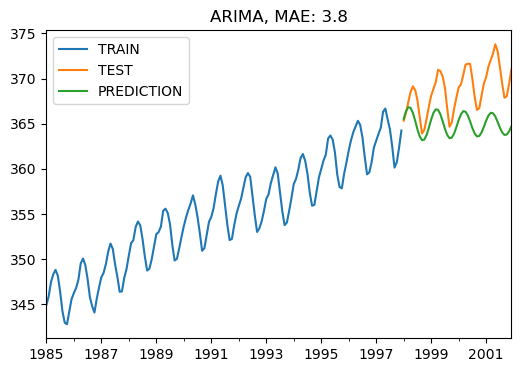

In [24]:
plot_co2(train, test, y_pred, "ARIMA")

In [25]:
def arima_optimizer_mae(train, orders):
    best_mae, best_orders = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(48)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_orders = mae, order
            print('ARIMA%s MAE=%.2f' % (order, mae))
        except:
            continue
    print('Best ARIMA%s MAE=%.2f' % (best_orders, best_mae))
    return best_orders

In [26]:
best_params_mae = arima_optimizer_mae(train, pdq)

ARIMA(1, 1, 1) MAE=2.30
ARIMA(1, 1, 2) MAE=3.21
ARIMA(1, 1, 3) MAE=3.34
ARIMA(1, 2, 1) MAE=42.64
ARIMA(1, 2, 2) MAE=1.81
ARIMA(1, 2, 3) MAE=1.79
ARIMA(1, 3, 1) MAE=43.55
ARIMA(1, 3, 2) MAE=43.19
ARIMA(1, 3, 3) MAE=34.60
ARIMA(2, 1, 1) MAE=4.79
ARIMA(2, 1, 2) MAE=4.73
ARIMA(2, 1, 3) MAE=3.80
ARIMA(2, 2, 1) MAE=1.99
ARIMA(2, 2, 2) MAE=32.18
ARIMA(2, 2, 3) MAE=2.40
ARIMA(2, 3, 1) MAE=42.03
ARIMA(2, 3, 2) MAE=42.76
ARIMA(2, 3, 3) MAE=32.75
ARIMA(3, 1, 1) MAE=4.75
ARIMA(3, 1, 2) MAE=4.78
ARIMA(3, 1, 3) MAE=3.52
ARIMA(3, 2, 1) MAE=2.46
ARIMA(3, 2, 2) MAE=1.99
ARIMA(3, 2, 3) MAE=2.06
ARIMA(3, 3, 1) MAE=12.37
ARIMA(3, 3, 2) MAE=2.34
ARIMA(3, 3, 3) MAE=34.50
Best ARIMA(1, 2, 3) MAE=1.79


In [27]:
arima_model = ARIMA(train, order=best_params_mae).fit()

In [28]:
y_pred = arima_model.forecast(48)
y_pred.head()

1998-01-01    365.219001
1998-02-01    365.662665
1998-03-01    365.905120
1998-04-01    366.067805
1998-05-01    366.198865
Freq: MS, Name: predicted_mean, dtype: float64

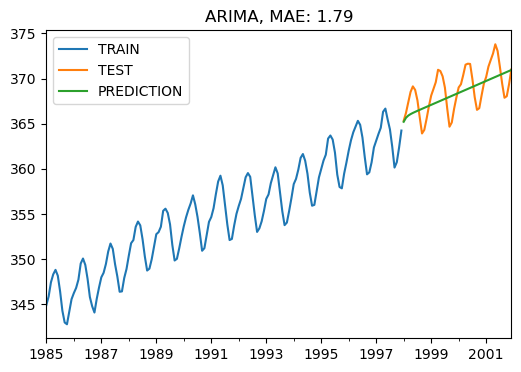

In [29]:
plot_co2(train, test, y_pred, "ARIMA")